In [ ]:
#upload csv files (mask-use-by-county.csv & us-counties-2020-extra-data.csv)

from google.colab import files

uploaded = files.upload()

Saving mask-use-by-county.csv to mask-use-by-county.csv


In [ ]:
#importing libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
#Sorting data frames to a point where they can train our models


#Create dataframes from csv files

masks_df = pd.read_csv('mask-use-by-county.csv') #df made from csv of mask use by county (data from july 2020)
covid_df = pd.read_csv('us-counties-2020-extra-data.csv') #creates df made from csv of covid rates by counties


#Cleaning

covid_df = covid_df.rename(columns={"geoid": "fips"}) #change name of geoid column to fips (they are the same thing)
covid_df['fips'] = covid_df['fips'].str[4:] #Remove the USA- at the start of each fips id
covid_df['fips'] = pd.to_numeric(covid_df['fips']) #Removes the 0s from the start of the fips (01001 -> 1001) by turning the fips into integers
covid_df = covid_df[covid_df['date'] == '2020-06-14'] #Only keeps the data from the day the mask use survey ended(july 14th 2020)


#Removes the fips that the datasets don't share

#removes the rows that need to be removed from covid_df
for index, row in covid_df.iterrows():
  if int(row["fips"]) not in list(masks_df.loc[:,'COUNTYFP']) or int(row["cases"]) < 0 or int(row["deaths"]) < 0: #sees if element in fips column matches with any element in COUNTYFP column
    covid_df = covid_df.drop(index) 

#removes the rows that need to be removed from masks_df
for index, row in masks_df.iterrows():
  if int(row["COUNTYFP"]) not in list(covid_df.loc[:,'fips']): 
    masks_df = masks_df.drop(index)


#Organizing

covid_df = covid_df.sort_values(by=['fips']) #sort by fips on both df (should start with 1001)
masks_df = masks_df.sort_values(by=['COUNTYFP']) #sort by fips on both df (should start with 1001)
masks_df = masks_df.set_index('COUNTYFP') #Makes fips/Countyfp the index of the masks_df, so that it will not interfere with our weighted average calculation


#Formatting mask use survey data, so that it's understood by our classifier

#Weighting the percentages for each row
#'NEVER' has value of 1
masks_df['RARELY'] = masks_df['RARELY'] * 2 
masks_df['SOMETIMES'] = masks_df['SOMETIMES'] * 3 
masks_df['FREQUENTLY'] = masks_df['FREQUENTLY'] * 4 
masks_df['ALWAYS'] = masks_df['ALWAYS'] * 5 

#RARELY has value of 2
#RARELY has value of 3
#FREQUENTLY has value of 4
#ALWAYS has value of 5


#putting the weighted averages into masks_df covid_df as a column
masks_df['weighted_avg'] = (masks_df.mean(axis=1)/5).to_numpy()
covid_df['weighted_avg'] = (masks_df.mean(axis=1)/5).to_numpy()


#Finds q1, median, and q3 of the weighted averages
maskuse_q1 = masks_df.describe()['weighted_avg']['25%']
maskuse_med = masks_df.describe()['weighted_avg']['50%']
maskuse_q3 = masks_df.describe()['weighted_avg']['75%']

#Makes 4 dataframes each containing a quarter of the counties based on their frequency of mask use (q1 having the counties with the least mask use; q4 having the counties with the most mask use)
quarter_one = covid_df[covid_df['weighted_avg'] < maskuse_q1] #Lowest mask use quarter
quarter_two = covid_df[(covid_df['weighted_avg'] < maskuse_med) & (covid_df['weighted_avg'] >= maskuse_q1)] #2nd lowest mask use quarter
quarter_three = covid_df[(covid_df['weighted_avg'] >= maskuse_med) & (covid_df['weighted_avg'] < maskuse_q3)] #2nd highest mask use quarter
quarter_four = covid_df[covid_df['weighted_avg'] >= maskuse_q3] #Highest mask use quarter

#Makes an array listing each county's mask_use quadrant. These will be our labels
quadrants_array = []
for index, row in covid_df.iterrows():
  if int(row["fips"]) in list(quarter_one.loc[:,'fips']):
    quadrants_array.append('q1')
  elif int(row["fips"]) in list(quarter_two.loc[:,'fips']):
    quadrants_array.append('q2')
  elif int(row["fips"]) in list(quarter_three.loc[:,'fips']):
    quadrants_array.append('q3')
  elif int(row["fips"]) in list(quarter_four.loc[:,'fips']):
    quadrants_array.append('q4')

#Drops columns not being used to train our classifiers
covid_df = covid_df.drop(columns=['date', 'fips', 'county', 'state', 'weighted_avg'])

#Turns covid_df to a 2D array, so the information can be fed to our classifiers
covid_array = covid_df.to_numpy() #converts the df into an nparray for train test split 

In [ ]:
#Finds information about Zach and Kailen's hometown county

covid_df[(covid_df['county'] == 'Middlesex') & (covid_df['state'] == 'Massachusetts')]

#Only works if 
#covid_df = covid_df.drop(columns=['date', 'fips', 'county', 'state', 'weighted_avg'])
#is not run

,date,fips,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,weighted_avg
240381,2020-06-14,25017,Middlesex,Massachusetts,39,63.0,3.91,8,13.63,0.85,0.18664


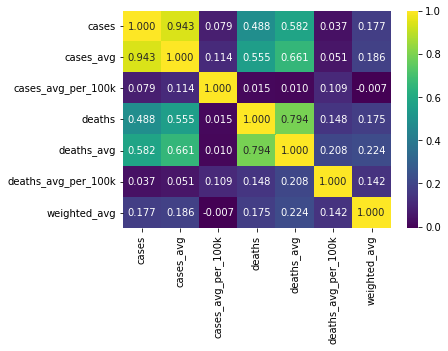

In [ ]:
#Heatmap of correlationss

#Adding weighted_avg column back to covid_df because it was removed
covid_df['weighted_avg'] = (masks_df.mean(axis=1)/5).to_numpy()

#plotting heatmap
sns.heatmap(covid_df.corr(), annot=True, fmt=".3f", cmap='viridis')
plt.show()

#removing weighted_avg column again so it doesn't interfere with training models
covid_df = covid_df.drop(columns=['weighted_avg']) 



In [ ]:
#Train Test Split

data_train, data_test, label_train, label_test = train_test_split(covid_array, quadrants_array, test_size=0.2)

19 is the best value for n_neighbors


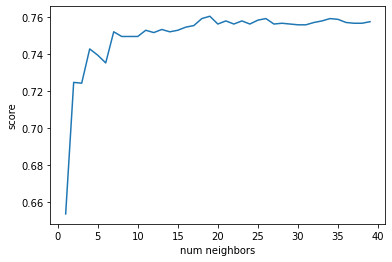

In [ ]:
#Finds best value for n_neighbors in KNN

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import numpy as np
max_score = 0
num_neighbors = []
score = []

#finds the highest score and the number of neighbors associated with it
for i in range(1,40):
  cv_score = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=i), data_train, label_train))
  num_neighbors.append(i)
  score.append(cv_score)
  if max_score < cv_score:
    max_score = cv_score
    best_n_neighbors = i #optimal number of neighbors

#Reports optimal number of neighbors for knn
print(f'{best_n_neighbors} is the best value for n_neighbors')

#Plotting
plt.xlabel("num neighbors")
plt.ylabel("score")
plt.plot(num_neighbors, score)

KNN accuracy: 0.7356902356902357
predicted quartile: ['q2']
actual quartile: q3


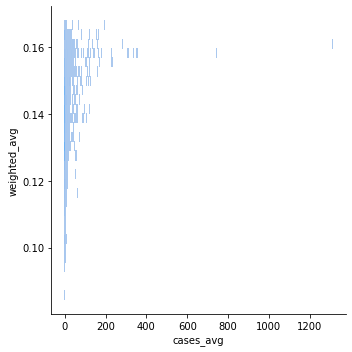

In [ ]:
#K-Nearest Neighbors

#Training
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors).fit(data_train, label_train)

#Scoring
print(f'KNN accuracy: {knn.score(data_test,label_test)}')

#Finding Middlesex county's index in covid_df and predicting the county's mask use with our classifier
for index, row in covid_df.iterrows():
  if index == 240381:
    middlesex = list(row)
print(f'''predicted quartile: {knn.predict([middlesex])}
actual quartile: {quadrants_array[1171]}''') #We found 1171 to be the index of Middlesex in the quadrants_array because it is the 1172nd row in covid_df 


#Adding weighted_avg column back to covid_df because it was removed
covid_df['weighted_avg'] = (masks_df.mean(axis=1)/5).to_numpy()

#Plotting cases, weighted_avg
sns.displot(
    x='cases_avg',
    y='weighted_avg',
    data=covid_df,
)

#removing weighted_avg column again so it doesn't interfere with training models
covid_df = covid_df.drop(columns=['weighted_avg']) 

4 is the best value for n_neighbors


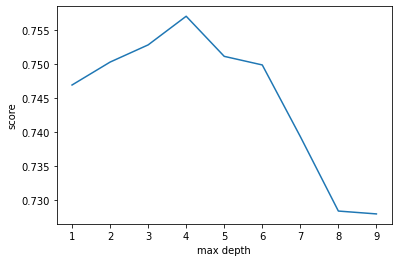

In [ ]:
#Finds best value for max_depth in Decision Tree


score_max = 0
max_depth = []
score = []

#finds the highest score and the max depth associated with it
for i in range(1,10):
  cv_score = np.mean(cross_val_score(DecisionTreeClassifier(criterion="entropy", random_state=100, max_depth = i), data_train, label_train))
  max_depth.append(i)
  score.append(cv_score)
  if score_max < cv_score:
    score_max = cv_score
    best_depth = i

#Reports optimal max depth for dtree
print(f'{best_depth} is the best value for n_neighbors')

#Plotting
plt.xlabel("max depth")
plt.ylabel("score")
plt.plot(max_depth, score)

Decision Tree Accuracy: 0.7474747474747475
predicted quartile: ['q3']
actual quartile: q3


[Text(0.5, 0.9, 'deaths_avg <= 0.85\nentropy = 1.042\nsamples = 2375\nvalue = [1741, 492, 142]\nclass = q1'),
 Text(0.25, 0.7, 'deaths_avg <= 0.045\nentropy = 0.934\nsamples = 2219\nvalue = [1712, 412, 95]\nclass = q1'),
 Text(0.125, 0.5, 'deaths_avg_per_100k <= 0.155\nentropy = 0.776\nsamples = 1434\nvalue = [1185, 209, 40]\nclass = q1'),
 Text(0.0625, 0.3, 'cases_avg <= 1.73\nentropy = 0.798\nsamples = 1302\nvalue = [1068, 194, 40]\nclass = q1'),
 Text(0.03125, 0.1, 'entropy = 0.747\nsamples = 1105\nvalue = [924, 152, 29]\nclass = q1'),
 Text(0.09375, 0.1, 'entropy = 1.038\nsamples = 197\nvalue = [144, 42, 11]\nclass = q1'),
 Text(0.1875, 0.3, 'cases_avg <= 1.255\nentropy = 0.511\nsamples = 132\nvalue = [117, 15, 0]\nclass = q1'),
 Text(0.15625, 0.1, 'entropy = 0.61\nsamples = 100\nvalue = [85, 15, 0]\nclass = q1'),
 Text(0.21875, 0.1, 'entropy = 0.0\nsamples = 32\nvalue = [32, 0, 0]\nclass = q1'),
 Text(0.375, 0.5, 'deaths_avg_per_100k <= 0.045\nentropy = 1.159\nsamples = 785\nvalue

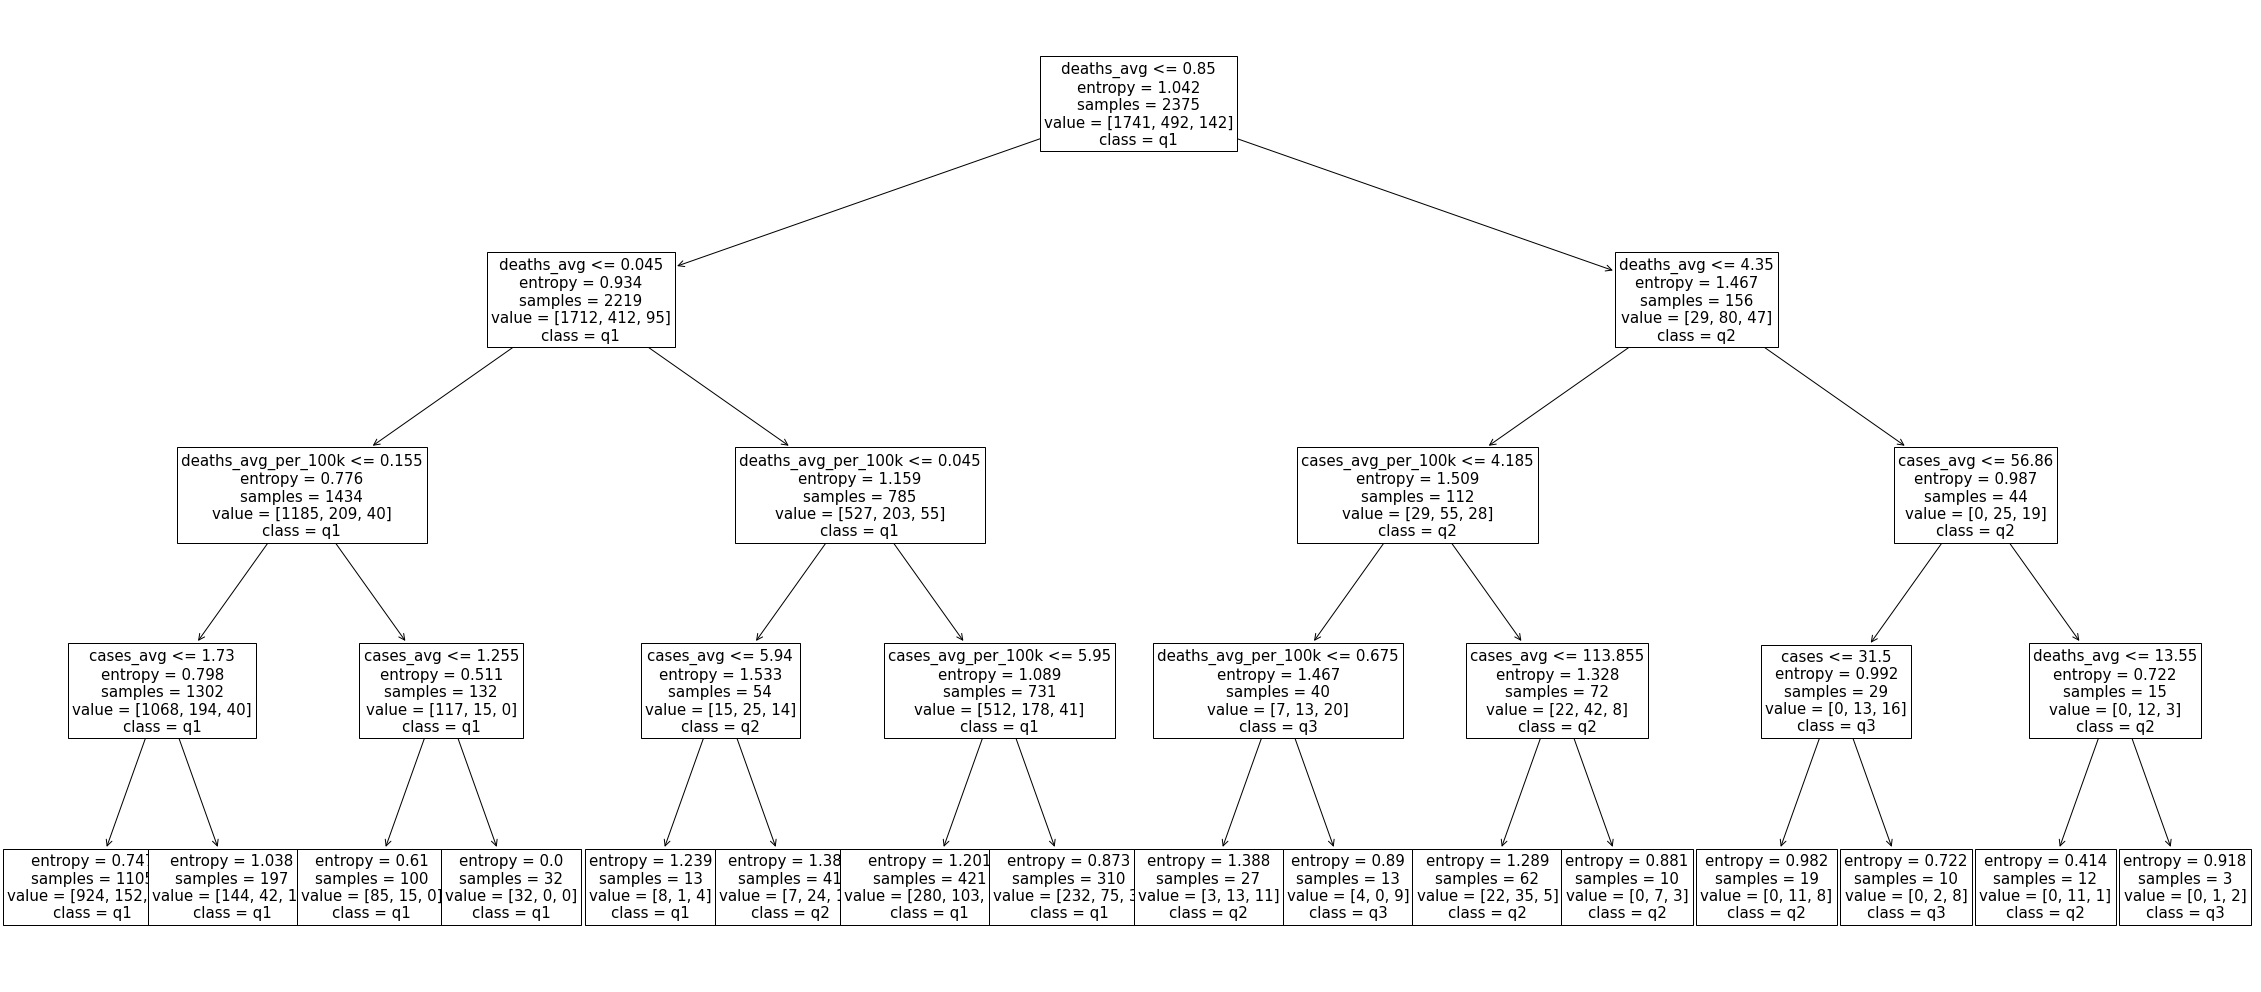

In [ ]:
#Decision Tree

#Trains and scores Decision Tree
dtree = DecisionTreeClassifier(criterion="entropy", random_state=100, max_depth = best_depth)
dtree.fit(data_train, label_train)
print(f'Decision Tree Accuracy: {dtree.score(data_test, label_test)}')

#Predicts Middlesex county
print(f'''predicted quartile: {dtree.predict([middlesex])}
actual quartile: {quadrants_array[1171]}''') #We found 1171 to be the index of Middlesex in the quadrants_array because it is the 1172nd row in covid_df 

#Plots decision tree
plt.figure(figsize=(40,18))
tree.plot_tree(dtree, feature_names = ['cases', 'cases_avg', 'cases_avg_per_100k', 'deaths', 'deaths_avg', 'deaths_avg_per_100k'], class_names = ['q1', 'q2', 'q3', 'q4'], fontsize=15)

In [ ]:
print(list(covid_df.columns)) #['date', 'geoid', 'county', 'state', 'cases', 'cases_avg', 'cases_avg_per_100k', 'deaths', 'deaths_avg', 'deaths_avg_per_100k']
print(list(masks_df.columns)) #['COUNTYFP', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']

['cases', 'cases_avg', 'cases_avg_per_100k', 'deaths', 'deaths_avg', 'deaths_avg_per_100k']
['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'weighted_avg']


In [ ]:
#For testing
covid_df.head()

,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
241585,26,13.57,24.29,0,0.09,0.17
241584,3,7.14,3.20,0,0.22,0.10
241583,8,5.86,23.73,0,0.03,0.14
241582,4,3.38,15.07,0,0.03,0.11
241581,8,5.43,9.39,0,0.02,0.03


In [ ]:
#For testing
masks_df.head()

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,weighted_avg
COUNTYFP,,,,,,
1001,0.053,0.148,0.402,1.180,2.220,0.16012
1003,0.083,0.118,0.294,1.292,2.180,0.15868
1005,0.067,0.242,0.360,0.804,2.455,0.15712
1007,0.020,0.068,0.288,1.112,2.860,0.17392
1009,0.053,0.228,0.540,0.776,2.295,0.15568
